---
---

# Project: Web Scraper
###### [ReDI School of Digital Integration](https://de.redi-school.org/)

---
---

### Summary:
This work was realised as a final project for the course "Data Science" of the ReDI School of Integration.<br>
From the broad field of Data Science, this project focuses on obtaining data through web scraping and analyse it.<br>
Part of the project was to learn about the technologies needed to do this, in this case BeautifulSoup.<br>
The biggest challenge, however, was getting into the structure of the website, understanding it, and based on that,<br>
writing the algorithm it would take to scrap the page in a completely automated way.<br>
It should be noted that every website has more or less the same structure, but there are significant differences in how the operator of the website uses it.<br>
As an example, in some cases the website does not follow a logical subdivision, this was to be recognised and dealt with accordingly.<br>
It took most of my time to scrape the first information, after that it was all self-running.<br>
Then I compared some data with each other and saved the outcome in a new column.<br>
After that I cleaned up the data a bit and started analysing it.<br>
In the end, after writing the algorithm for it, I revised the code and put the relevant lines into functions, thus reducing the code to about a third.

Website to be scraped: [Metacritic](https://www.metacritic.com/)

---

## 1. Scraping Data

#### Importing the tools

In [1]:
from bs4 import BeautifulSoup as bs
import requests as rq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

---

#### Defining the functions

**get_pages(console)**<br>
Takes the console as a parameter, adds it to the URL.<br>
Then it "goes" into the page to just scrape the last page number.

In [2]:
def get_pages(console):
    url = rq.get("https://www.metacritic.com/browse/games/release-date/available/{}/date?page={}".format(console, 0), headers={"User-agent": "Mozilla/5.0"})
    soup = bs(url.text, "html.parser")
    last_page = int(soup.find("li", class_="page last_page").find("a", class_="page_num").getText())
    return last_page

**scraper(console, pages)**<br>
Takes as parameter the console and the page number we scraped before.<br>
In a loop, the console and gradually the page number are added (iterating through the pages).<br>
In another loop we scrape the individual data of the respective columns for each page.

In [3]:
def scraper(console, pages):
    for page in range(pages):
        url = rq.get("https://www.metacritic.com/browse/games/release-date/available/{}/date?page={}".format(console, page), headers={"User-agent": "Mozilla/5.0"})
        soup = bs(url.text, "html.parser")
        content = soup.find_all("table", class_="clamp-list")
    
        for table in range(len(content)):
            table_rows = content[table].find_all("tr")

            for row in range(len(table_rows)):
                for title in table_rows[row].find_all("a", {"class":"title"}):
                    frame_dict["title"].append(title.find("h3").text.strip())

                for platform in table_rows[row].find_all("span", {"class":"data"}):
                    frame_dict["platform"].append(platform.text.strip())

                for date in table_rows[row].find_all("span", {"class":""}):
                    frame_dict["date"].append(date.text.strip())

                for meta_score in table_rows[row].find_all("div", {"class":"clamp-metascore"}):
                    frame_dict["meta_score"].append(meta_score.text.replace("Metascore:", "").strip())

                for user_score in table_rows[row].find_all("div", {"class":"clamp-userscore"}):
                    frame_dict["user_score"].append(user_score.text.replace("User Score:", "").strip())

                for summary in table_rows[row].find_all("div", {"class":"summary"}):
                    frame_dict["summary"].append(summary.text.strip())

---

#### Specifing the consoles for which the data is to be obtained and predefining the frame as a dictionary

In [4]:
console = ["ps4", "xboxone", "switch"]
frame_dict = {"title":[], "platform":[], "date":[], "meta_score":[], "user_score":[], "summary":[]}

---

#### Here the entire data is scraped for the individual cosols

In [5]:
scraper(console[0], get_pages(console[0])) # PlayStation 4
scraper(console[1], get_pages(console[1])) # Xbox One
scraper(console[2], get_pages(console[2])) # Nintendo Switch

---

#### Converting the dictionary into a pandas data frame and replacing non-numeric data with 0
(for easier handling later for analysing)

In [6]:
df = (pd.DataFrame.from_dict(frame_dict))

In [7]:
df.loc[df["meta_score"] == "tbd", "meta_score"] = 0
df.loc[df["user_score"] == "tbd", "user_score"] = 0

---

#### Creating new column and comparing data 
Calculating the difference of the data in the columns "meta_score" and "user_score".<br>
(only in the case that both values are not 0)<br>
(meta_score and user_score have a different score range, one x of 100 the other x of 10,<br>
these have been transformed in the calculation accordingly)<br>
Storing the result in the newly created column "score_deviation". 

In [8]:
df["score_deviation"] = 0

In [9]:
for i in range(len(df)):
    if df.iloc[i, 3] != 0 and df.iloc[i, 4] != 0:
        df.iloc[i, 6] = abs(float(df.iloc[i, 3]) - (float(df.iloc[i, 4])*10))

---

#### Preparing/Cleaning up the data
(I have tried to scrape the data clean from the beginning, so there is actually not much to clean.<br>
The only thing that needs to be corrected is a few wrong allocations, which is the fault of the website operator)

In [10]:
df.drop(df[(df["title"] == "MX vs ATV Reflex") & (df["platform"] == "Xbox One")].index, inplace=True)
df.drop(df[(df["title"] == "Interpol") & (df["platform"] == "Xbox One")].index, inplace=True)
df.drop(df[(df["title"] == "Passage 4 XL") & (df["platform"] == "Xbox One")].index, inplace=True)

df["date"] = pd.to_datetime(df["date"])

---

#### Saving the whole data frame in a .csv file

In [11]:
df.to_csv("games.csv")

---

## 2. Data Analysis

#### Overview

**Games total:**

In [12]:
games_total = len(df["title"])
games_total

19846

**Unique game titles:**

In [13]:
unique_titles = len(df["title"].unique())
unique_titles

12017

**Years games were released:**

In [14]:
df["year"] = [y.year for y in df["date"]]
years_total = list(df["year"].unique())
years_total.reverse()
years_total

[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

**Games released per year:**

In [15]:
df["year"].groupby(df["year"]).count()

year
2013      68
2014     336
2015     821
2016    1324
2017    2192
2018    3309
2019    3597
2020    3925
2021    4274
Name: year, dtype: int64

<AxesSubplot:ylabel='title'>

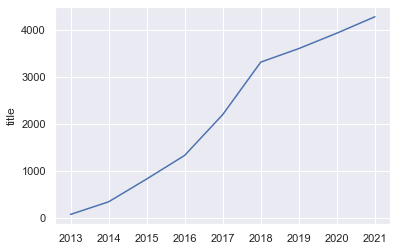

In [16]:
sns.set_theme(style="darkgrid")
sns.lineplot(x=years_total, y=df["title"].groupby(df["year"]).count())

**Games with suspicious Metascore:**

In [17]:
# This is the number of games that have a metascore and a userscore that are compared with each other.
score_compared_total = len(df[df["score_deviation"] > 0]) 
sct_percent = round(score_compared_total/games_total*100,2)
score_compared_total

5317

In [18]:
# This is the number of games where the difference in the scores is suspiciously different (The value is self-reported, depending on what you consider suspicious).
score_sus = len(df[df["score_deviation"] >= 20])
ssus_percent = round(score_sus/score_compared_total*100,2)
score_sus

714

**Conclusion**

In [19]:
print(f"Out of {games_total} games, "
      f"{score_compared_total} ({sct_percent}%) games have both a meta score and a user score, "
      f"of which {score_sus} ({ssus_percent}%) are games where the scores are suspiciously different.")

Out of 19846 games, 5317 (26.79%) games have both a meta score and a user score, of which 714 (13.43%) are games where the scores are suspiciously different.


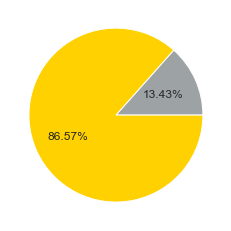

In [20]:
plt.pie([score_sus, (score_compared_total-score_sus)], colors = ["#9da3a4","#ffd100"], autopct="%.2f%%")
plt.show()

---

#### PlayStation 4

**PlayStation 4 games total:**

In [21]:
ps4_total = len(df[df["platform"] == "PlayStation 4"])
ps4_total

7114

**Years PlayStation 4 games were released:**

In [22]:
years_ps4 = list(df["year"][df["platform"] == "PlayStation 4"].unique())
years_ps4.reverse()
years_ps4

[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

**PlayStation 4 games released per year:**

In [23]:
df["platform"][df["platform"] == "PlayStation 4"].groupby(df["year"]).count()

year
2013      37
2014     177
2015     460
2016     788
2017    1032
2018    1127
2019    1136
2020    1154
2021    1203
Name: platform, dtype: int64

<AxesSubplot:ylabel='title'>

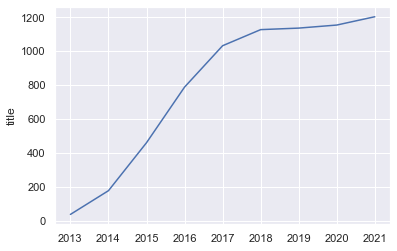

In [24]:
sns.set_theme(style="darkgrid")
sns.lineplot(x=years_ps4, y=df["title"][df["platform"] == "PlayStation 4"].groupby(df["year"]).count())

**PlayStation 4 games with suspicious Metascore:**

In [25]:
# This is the number of games that have a metascore and a userscore that are compared with each other.
ps4_score_compared_total = len(df[(df["score_deviation"] > 0) & (df["platform"] == "PlayStation 4")])
ps4_sct_percent = round(ps4_score_compared_total/ps4_total*100, 2)
ps4_score_compared_total

2255

In [26]:
# This is the number of games where the difference in the scores is suspiciously different (The value is self-reported, depending on what you consider suspicious).
ps4_score_sus = len(df[(df["score_deviation"] >= 20) & (df["platform"] == "PlayStation 4")])
ps4_ssus_percent = round(ps4_score_sus/ps4_score_compared_total*100, 2)
ps4_score_sus

354

**Conclusion**

In [27]:
print(f"Out of {ps4_total} games, "
      f"{ps4_score_compared_total} ({ps4_sct_percent}%) games have both a meta score and a user score, "
      f"of which {ps4_score_sus} ({ps4_ssus_percent}%) are games where the scores are suspiciously different.")

Out of 7114 games, 2255 (31.7%) games have both a meta score and a user score, of which 354 (15.7%) are games where the scores are suspiciously different.


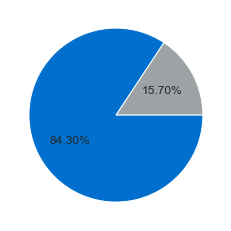

In [28]:
plt.pie([ps4_score_sus, (ps4_score_compared_total-ps4_score_sus)], colors = ["#9da3a4","#006FCD"], autopct="%.2f%%")
plt.show()

---

#### Xbox One

**Xbox One games total:**

In [29]:
xboxone_total = len(df[df["platform"] == "Xbox One"])
xboxone_total

5677

**Years Xbox One games were released:**

In [30]:
years_xboxone = list(df["year"][df["platform"] == "Xbox One"].unique())
years_xboxone.reverse()
years_xboxone

[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

**Xbox One games released per year:**

In [31]:
df["platform"][df["platform"] == "Xbox One"].groupby(df["year"]).count()

year
2013      31
2014     159
2015     361
2016     536
2017     790
2018     918
2019     852
2020     970
2021    1060
Name: platform, dtype: int64

<AxesSubplot:ylabel='title'>

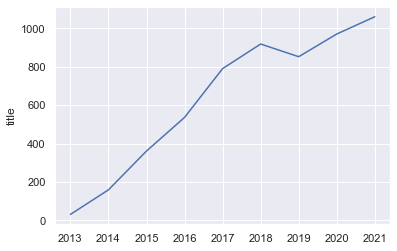

In [32]:
sns.set_theme(style="darkgrid")
sns.lineplot(x=years_xboxone, y=df["title"][df["platform"] == "Xbox One"].groupby(df["year"]).count())

**Xbox One games with suspicious Metascore:**

In [33]:
# This is the number of games that have a metascore and a userscore that are compared with each other.
xbxo_score_compared_total = len(df[(df["score_deviation"] > 0) & (df["platform"] == "Xbox One")]) 
xbxo_sct_percent = round(xbxo_score_compared_total/xboxone_total*100, 2)
xbxo_score_compared_total

1453

In [34]:
# This is the number of games where the difference in the scores is suspiciously different (The value is self-reported, depending on what you consider suspicious).
xbxo_score_sus = len(df[(df["score_deviation"] >= 20) & (df["platform"] == "Xbox One")])
xbxo_ssus_percent = round(xbxo_score_sus/xbxo_score_compared_total*100, 2)
xbxo_score_sus

255

**Conclusion**

In [35]:
print(f"Out of {xboxone_total} games, "
      f"{xbxo_score_compared_total} ({xbxo_sct_percent}%) games have both a meta score and a user score, "
      f"of which {xbxo_score_sus} ({xbxo_ssus_percent}%) are games where the scores are suspiciously different.")

Out of 5677 games, 1453 (25.59%) games have both a meta score and a user score, of which 255 (17.55%) are games where the scores are suspiciously different.


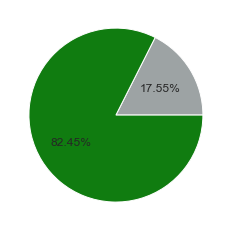

In [36]:
plt.pie([xbxo_score_sus, (xbxo_score_compared_total-xbxo_score_sus)], colors = ["#9da3a4","#107C10"], autopct="%.2f%%")
plt.show()

---

#### Nintendo Switch

**Nintendo Switch games total:**

In [37]:
switch_total = len(df[df["platform"] == "Switch"])
switch_total

7055

**Years Nintendo Switch games were released:**

In [38]:
years_switch = list(df["year"][df["platform"] == "Switch"].unique())
years_switch.reverse()
years_switch

[2017, 2018, 2019, 2020, 2021]

**Nintendo Switch games released per year:**

In [39]:
df["platform"][df["platform"] == "Switch"].groupby(df["year"]).count()

year
2017     370
2018    1264
2019    1609
2020    1801
2021    2011
Name: platform, dtype: int64

<AxesSubplot:ylabel='title'>

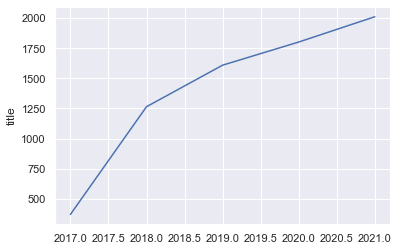

In [40]:
sns.set_theme(style="darkgrid")
sns.lineplot(x=years_switch, y=df["title"][df["platform"] == "Switch"].groupby(df["year"]).count())

**Nintendo Switch games with suspicious Metascore:**

In [41]:
# This is the number of games that have a metascore and a userscore that are compared with each other.
switch_score_compared_total = len(df[(df["score_deviation"] > 0) & (df["platform"] == "Switch")]) 
switch_sct_percent = round(switch_score_compared_total/switch_total*100, 2)
switch_score_compared_total

1609

In [42]:
# This is the number of games where the difference in the scores is suspiciously different (The value is self-reported, depending on what you consider suspicious).
switch_score_sus = len(df[(df["score_deviation"] >= 20) & (df["platform"] == "Switch")])
switch_ssus_percent = round(switch_score_sus/switch_score_compared_total*100, 2)
switch_score_sus

105

**Conclusion**

In [43]:
print(f"Out of {switch_total} games, "
      f"{switch_score_compared_total} ({switch_sct_percent}%) games have both a meta score and a user score, "
      f"of which {switch_score_sus} ({switch_ssus_percent}%) are games where the scores are suspiciously different.")

Out of 7055 games, 1609 (22.81%) games have both a meta score and a user score, of which 105 (6.53%) are games where the scores are suspiciously different.


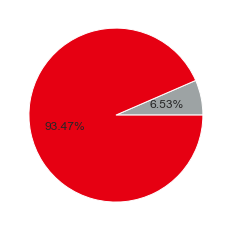

In [44]:
plt.pie([switch_score_sus, (switch_score_compared_total-switch_score_sus)], colors = ["#9da3a4","#e60012"], autopct="%.2f%%")
plt.show()